### Imports

In [1]:
%load_ext autoreload

In [2]:
from os.path import join
import torch
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar, LearningRateMonitor
from pytorch_lightning.utilities.model_summary import ModelSummary
import sfaira
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import yaml
from pathlib import Path
from math import ceil
import os
root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

2023-01-12 10:50:31.849909: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-12 10:50:41.535473: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
%autoreload
# from scgm.models.estimators.base import EstimatorGM
from scgm.models.generative_models.autoencoder import AutoEncoder
from scgm.data.utils import get_estimator, get_model_checkpoint, get_train_val_test_split
from sfairazero.estimators.torch.datamodules import SfairaDataModule

### Explore MLP Autoencoder with sfairazero

In [6]:
model_type = 'mlp'
weight_decay = 0.0
loss_func = 'MSE'
batch_size = 4096  # To Do: increase this to get less noisy loss curves
lr = 0.1
RETRIEVAL_BATCH_SIZE = 35000
SHUFFLE_BUFFER_SIZE = 15000
version = 'Dummy'
resume_from_checkpoint = None
checkpoint_interval = 1
batch_norm = True
dropout = 0.25
gain_weight_init_first_layer = 4.
gain_weight_init = 0.75

In [8]:
# GET GPU AND ARGS
if torch.cuda.is_available():
    print(f'CUDA_VISIBLE_DEVICES: {os.environ["CUDA_VISIBLE_DEVICES"]}')

# GET HYPERPARAMETER
if model_type == 'mlp':
    hparams = yaml.safe_load(Path(root + '/scgm/models/generative_models/hparams_ae.yaml').read_text())
    model_class = AutoEncoder  # maybe we need better variable names...
else:
    raise ValueError('Only MLP is implemented yet, TO DO: implement TabNet')

# FIX SEED FOR REPRODUCIBILITY
seed_everything(90)

# CHECKPOINT HANDLING
subfolder = model_type + '_' + version + "/"
CHECKPOINT_PATH = root + "/trained_models/autoencoder/" \
                  + subfolder
Path(CHECKPOINT_PATH).mkdir(parents=True, exist_ok=True)

# GET ESTIMATOR
estim = get_estimator()  # returns blank estimator without initializations

estim.yield_cell_type=True
estim.yield_organ=True
estim.yield_assay_sc=True
# estim.yield_dataset_id=True
estim.yield_data_batch=True
estim.yield_tech_sample=True


estim.init_datamodule(
    batch_size=batch_size,
    validation_batch_size=batch_size,
    retrieval_batch_size=RETRIEVAL_BATCH_SIZE,
    shuffle_buffer=SHUFFLE_BUFFER_SIZE,
    prefetch=ceil(RETRIEVAL_BATCH_SIZE / batch_size),
)

estim.init_trainer(
    trainer_kwargs={
        'max_epochs': 1000,
        'gradient_clip_val': 1.,
        'gradient_clip_algorithm': 'norm',
        'default_root_dir': CHECKPOINT_PATH,
        'resume_from_checkpoint': get_model_checkpoint(CHECKPOINT_PATH, resume_from_checkpoint),
        'accelerator': 'gpu',
        'devices': 1,
        'num_sanity_val_steps': 0,
        'check_val_every_n_epoch': 1,
        'limit_train_batches': int(len(estim.datamodule.idx_train) / batch_size),
        'limit_val_batches': int(len(estim.datamodule.idx_val) / batch_size),
        'logger': [TensorBoardLogger(CHECKPOINT_PATH, name='default')],
        'log_every_n_steps': 100,
        'detect_anomaly': False,
        'enable_progress_bar': True,
        'enable_model_summary': False,
        'enable_checkpointing': True,
        'callbacks': [
            TQDMProgressBar(refresh_rate=300),
            LearningRateMonitor(logging_interval='step'),
            # Save the model with the best training loss
            ModelCheckpoint(filename='best_checkpoint_train', monitor='train_loss_epoch', mode='min',
                            every_n_epochs=checkpoint_interval, save_top_k=1),
            # Save the model with the best validation loss
            ModelCheckpoint(filename='best_checkpoint_val', monitor='val_loss', mode='min',
                            every_n_epochs=checkpoint_interval, save_top_k=1)
        ],
    }
)

estim.init_model(
    model_type=model_type,
    model_kwargs={
    'units_encoder': hparams['units'],
    'units_decoder': hparams['units'][::-1][1:],
    }
)

Global seed set to 90


CUDA_VISIBLE_DEVICES: 0


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/120 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=120` reached.
Restoring states from the checkpoint path at /home/icb/till.richter/git/scgm/trained_models/autoencoder/mlp_Dummy/.lr_find_3bd1e0db-4303-4f82-ae3b-95d805f6d519.ckpt


New lr:  0.03349654391578275


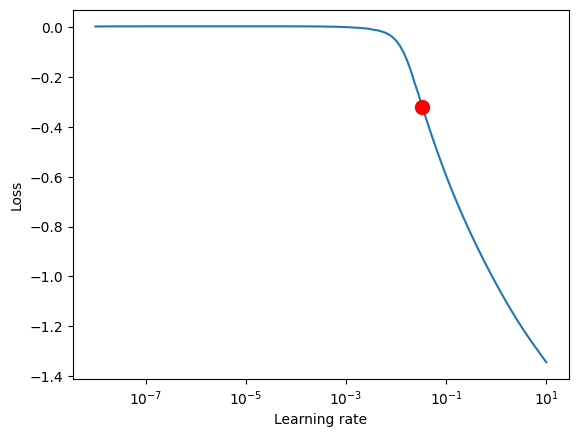

In [10]:
# Run learning rate finder
lr_find_kwargs = {'early_stop_threshold': None, 'min_lr': 1e-8, 'max_lr': 10., 'num_training': 120}

lr_finder = estim.trainer.tuner.lr_find(estim.model, estim.datamodule, **lr_find_kwargs)

# Results can be found in
lr_finder.results

# Plot with
fig = lr_finder.plot(suggest=True)
# fig.savefig('lr_finder_' + model + '_' + contrastive_method + '_' + augment_type +
#             str(augment_intensity) + '.jpg')

# Pick point based on plot, or get suggestion
new_lr = lr_finder.suggestion()
print('New lr: ', new_lr)

# update hparams of the model
estim.model.hparams.lr = new_lr